My first Data Science project all by myself. Exciting!

Loading Data and Initial Imports

In [72]:
import os
os.environ['SCIPY_ARRAY_API'] = '1'

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [43]:
loan = pd.read_csv("../data/input/loan.csv")

# Data Cleaning

Filling Missing Values

Finding out whether to use Mean or Median for our Numerical Columns

In [73]:
# Filling Numerical Values with Median cause they are right skewed
loan['ApplicantIncome'].fillna(loan['ApplicantIncome'].median(), inplace=True)
loan['CoapplicantIncome'].fillna(loan['CoapplicantIncome'].median(), inplace=True)
loan['LoanAmount'].fillna(loan['LoanAmount'].median(), inplace=True)

# Filling Categorical and Discrete Values with Mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    loan[col].fillna(loan[col].mode()[0], inplace=True)
    
print("Missing values after cleaning:")
print(loan.isna().sum())

Missing values after cleaning:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


C:\Users\Parsan Afzar\AppData\Local\Temp\ipykernel_8344\576441849.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan['ApplicantIncome'].fillna(loan['ApplicantIncome'].median(), inplace=True)
C:\Users\Parsan Afzar\AppData\Local\Temp\ipykernel_8344\576441849.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

Feature Engineering and Encoding

In [81]:
df_processed = loan.copy() # DataFrame for processed data

Filling NaN values:

In [82]:
df_processed.update(pd.DataFrame({
    
    # Median
    "ApplicantIncomde":  loan["ApplicantIncome"].fillna(loan["ApplicantIncome"].median()),
    "CoapplicantIncome": loan["CoapplicantIncome"].fillna(loan["CoapplicantIncome"].median()),
    "loanAmount":        loan["LoanAmount"].fillna(loan["LoanAmount"].median()),

    # Mode
    "Loan_Amount_Term":  loan["Loan_Amount_Term"].fillna(loan["Loan_Amount_Term"].mode()[0]),
    "Gender":            loan["Gender"].fillna(loan["Gender"].mode()[0]),
    "Married":           loan["Married"].fillna(loan["Married"].mode()[0]),
    "Self_Employed":     loan["Self_Employed"].fillna(loan["Self_Employed"].mode()[0]),
    "Dependents":        loan["Dependents"].fillna(loan["Dependents"].mode()[0]),
    "Credit_History":    loan["Credit_History"].fillna(loan["Credit_History"].mode()[0]),
}))

In [83]:
print(df_processed.isna().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


One_Hot Encoding for Nominal Columns

In [84]:
nominal_cols = ['Gender', 'Married', 'Self_Employed', 'Credit_History', 'Property_Area']
loan_hot_encoded = pd.get_dummies(loan, columns=nominal_cols, drop_first=True)
print(loan_hot_encoded.head())

  Dependents     Education  ApplicantIncome  CoapplicantIncome  LoanAmount  \
0          0      Graduate             5849                0.0       128.0   
1          1      Graduate             4583             1508.0       128.0   
2          0      Graduate             3000                0.0        66.0   
3          0  Not Graduate             2583             2358.0       120.0   
4          0      Graduate             6000                0.0       141.0   

   Loan_Amount_Term Loan_Status  Gender_Male  Married_Yes  Self_Employed_Yes  \
0             360.0           Y         True        False              False   
1             360.0           N         True         True              False   
2             360.0           Y         True         True               True   
3             360.0           Y         True         True              False   
4             360.0           Y         True        False              False   

   Credit_History_1.0  Property_Area_Semiurban  Pr

Label Encoding for ordinal columns

In [85]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
ordinal_cols = ['Education', 'Loan_Status']
for col in ordinal_cols:
    loan_hot_encoded[col] = le.fit_transform(loan_hot_encoded[col])

print(loan_hot_encoded.head())

  Dependents  Education  ApplicantIncome  CoapplicantIncome  LoanAmount  \
0          0          0             5849                0.0       128.0   
1          1          0             4583             1508.0       128.0   
2          0          0             3000                0.0        66.0   
3          0          1             2583             2358.0       120.0   
4          0          0             6000                0.0       141.0   

   Loan_Amount_Term  Loan_Status  Gender_Male  Married_Yes  Self_Employed_Yes  \
0             360.0            1         True        False              False   
1             360.0            0         True         True              False   
2             360.0            1         True         True               True   
3             360.0            1         True         True              False   
4             360.0            1         True        False              False   

   Credit_History_1.0  Property_Area_Semiurban  Property_Area_

In [86]:
# Just out of curiosity!!

married_crosstab = pd.crosstab(loan_hot_encoded['Married_Yes'], loan_hot_encoded['Loan_Status'])
print(married_crosstab)

credit_crosstab = pd.crosstab(loan_hot_encoded['Credit_History_1.0'], loan_hot_encoded['Loan_Status'])
print(f"\n{credit_crosstab}")

Loan_Status    0    1
Married_Yes          
False         79  134
True         113  288

Loan_Status           0    1
Credit_History_1.0          
False                82    7
True                110  415


In [87]:
X = loan_hot_encoded.drop('Loan_Status', axis=1)
y = loan_hot_encoded['Loan_Status']

In [88]:
from sklearn.model_selection import train_test_split

# Seperating X and y
X = loan_hot_encoded.drop('Loan_Status', axis=1)
y = loan_hot_encoded['Loan_Status']

# Splitting the dataset into training and testing set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

validation_ration = 0.20 / 0.85
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=validation_ration, random_state=42, stratify=y_train_val)

print(f"Total data size: {len(loan_hot_encoded)}")
print("-" * 30)
print(f"Training set size: {len(X_train)} ({len(X_train)/len(loan_hot_encoded):.0%})")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(loan_hot_encoded):.0%})")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(loan_hot_encoded):.0%})")

Total data size: 614
------------------------------
Training set size: 398 (65%)
Validation set size: 123 (20%)
Test set size: 93 (15%)


In [89]:
# Curiousity about the data
loan_hot_encoded['Total_Income'] = loan_hot_encoded['ApplicantIncome'] + loan_hot_encoded['CoapplicantIncome']

loan_hot_encoded['Loan_to_Income_Ratio'] = loan_hot_encoded['LoanAmount'] / loan_hot_encoded['Total_Income']

loan_hot_encoded['Loan_per_Month'] = loan_hot_encoded['LoanAmount'] / (loan_hot_encoded['Loan_Amount_Term'] / 12)

print(loan_hot_encoded[['LoanAmount', 'Total_Income', 'Loan_to_Income_Ratio', 'Loan_per_Month']].head())

   LoanAmount  Total_Income  Loan_to_Income_Ratio  Loan_per_Month
0       128.0        5849.0              0.021884        4.266667
1       128.0        6091.0              0.021015        4.266667
2        66.0        3000.0              0.022000        2.200000
3       120.0        4941.0              0.024287        4.000000
4       141.0        6000.0              0.023500        4.700000


In [90]:
from sklearn.preprocessing import StandardScaler

loan_hot_encoded['ApplicantIncome_Log']   = np.log1p(loan_hot_encoded['ApplicantIncome'])
loan_hot_encoded['CoapplicantIncome_Log'] = np.log1p(loan_hot_encoded['CoapplicantIncome'])
loan_hot_encoded['LoanAmount_Log']        = np.log1p(loan_hot_encoded['LoanAmount'])

loan_hot_encoded['Total_Income']        = loan_hot_encoded['ApplicantIncome'] + loan_hot_encoded['CoapplicantIncome']
loan_hot_encoded['Loan_to_Income_Ratio']= loan_hot_encoded['LoanAmount'] / loan_hot_encoded['Total_Income']
loan_hot_encoded['Loan_per_Month']      = loan_hot_encoded['LoanAmount'] / loan_hot_encoded['Loan_Amount_Term']

X = loan_hot_encoded.drop(columns=['Loan_Status',
                                   'ApplicantIncome',
                                   'CoapplicantIncome',
                                   'LoanAmount'])        
y = loan_hot_encoded['Loan_Status']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

cols_to_scale = ['ApplicantIncome_Log', 'CoapplicantIncome_Log', 'LoanAmount_Log',
                 'Total_Income', 'Loan_to_Income_Ratio', 'Loan_per_Month']

scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_val_scaled[cols_to_scale]   = scaler.transform(X_val[cols_to_scale])
X_test_scaled[cols_to_scale]  = scaler.transform(X_test[cols_to_scale])

print("\nScaled Data Head:")
print(X_train_scaled[cols_to_scale].head())


Scaled Data Head:
     ApplicantIncome_Log  CoapplicantIncome_Log  LoanAmount_Log  Total_Income  \
332            -0.648050              -1.065021       -1.155465     -0.666499   
320            -0.907933               0.911839       -0.210303     -0.390532   
49             -0.107521               0.924350        0.231920     -0.118703   
274            -0.147195              -1.065021       -0.691344     -0.496685   
25              1.257924              -1.065021        0.788329      0.404106   

     Loan_to_Income_Ratio  Loan_per_Month  
332              0.145022       -0.493857  
320              0.157956       -0.287872  
49              -0.084936       -0.152110  
274             -0.070931       -0.404909  
25              -0.407980        0.067919  


c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Parsan Afzar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The ma

Best parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}

Logistic Regression Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.86      0.39      0.54        49
           1       0.70      0.96      0.81        74

    accuracy                           0.73       123
   macro avg       0.78      0.67      0.67       123
weighted avg       0.77      0.73      0.70       123


Confusion Matrix for Logistic Regression:


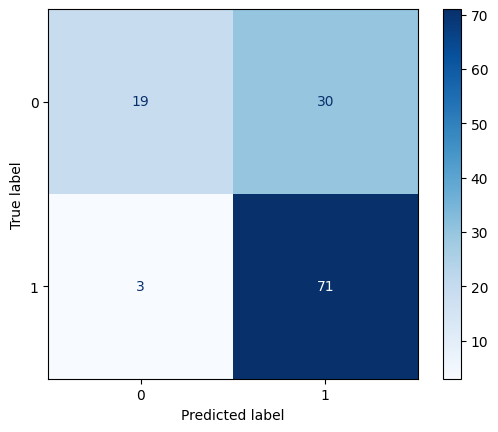

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

X_train_scaled_fixed = X_train_scaled.copy()
X_train_scaled_fixed['Dependents'] = X_train_scaled_fixed['Dependents'].replace('3+', 3).astype(int)

lr = LogisticRegression(random_state=42, max_iter=1000)
param_grid_lr = {
    'C':[0.01, 0.1, 1, 10, 100],
    'solver':['liblinear', 'saga'],
}

grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train_scaled_fixed, y_train)

print(f"Best parameters for Logistic Regression: {grid_lr.best_params_}")

best_lr = grid_lr.best_estimator_

X_val_scaled_fixed = X_val_scaled.copy()
X_val_scaled_fixed['Dependents'] = X_val_scaled_fixed['Dependents'].replace('3+', 3).astype(int)

y_pred_lr = best_lr.predict(X_val_scaled_fixed)

print("\nLogistic Regression Classification Report on Validation Set:")
print(classification_report(y_val, y_pred_lr))

print("\nConfusion Matrix for Logistic Regression:")
cm_lr = confusion_matrix(y_val, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp.plot(cmap='Blues')
plt.show()

Final Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.44      0.59        36
           1       0.81      0.98      0.89        87

    accuracy                           0.82       123
   macro avg       0.85      0.71      0.74       123
weighted avg       0.83      0.82      0.80       123

Final Confusion Matrix:


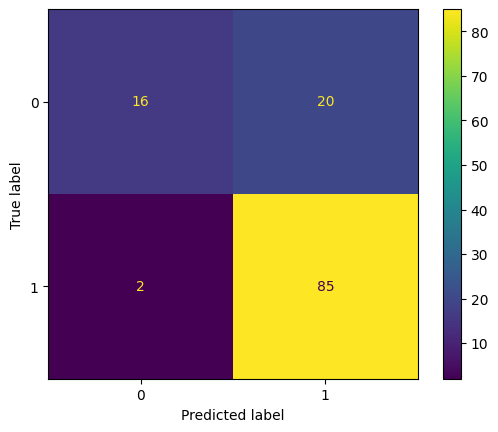

In [110]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

final_model = best_lr

X_test_scaled_fixed = X_test_scaled.copy()
X_test_scaled_fixed['Dependents'] = X_test_scaled_fixed['Dependents'].replace('3+', 3).astype(int)

test_predictions = final_model.predict(X_test_scaled_fixed)

print("Final Model Performance on Test Set:")
print(classification_report(y_test, test_predictions))

print("Final Confusion Matrix:")
cm_test = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot()
plt.show()

In [120]:
new_application = {
	'Gender': 'Male',
	'Married': 'Yes',
	'Dependents': '1',
	'Education': 'Graduate',
	'Self_Employed': 'No',
	'ApplicantIncome': 5000,
	'CoapplicantIncome': 2000,
	'LoanAmount': 150,
	'Loan_Amount_Term': 360.0,
	'Credit_History': 1.0,
	'Property_Area': 'Urban'
}
new_df = pd.DataFrame([new_application])

new_df['Education'] = new_df['Education'].map({'Graduate': 1, 'Not Graduate': 0})
new_df = pd.get_dummies(new_df)

new_df['ApplicantIncome_Log'] = np.log1p(new_df['ApplicantIncome'])
new_df['CoapplicantIncome_Log'] = np.log1p(new_df['CoapplicantIncome']) 
new_df['LoanAmount_Log'] = np.log1p(new_df['LoanAmount'])

new_df['Total_Income'] = new_df['ApplicantIncome'] + new_df['CoapplicantIncome']
new_df['Loan_to_Income_Ratio'] = new_df['LoanAmount'] / new_df['Total_Income']
new_df['Loan_per_Month'] = new_df['LoanAmount'] / (new_df['Loan_Amount_Term'] / 12)

final_cols = [
	'Dependents', 'Education', 'Loan_Amount_Term', 'Gender_Male',
	'Married_Yes', 'Self_Employed_Yes', 'Credit_History_1.0',
	'Property_Area_Semiurban', 'Property_Area_Urban', 'Total_Income',
	'Loan_to_Income_Ratio', 'Loan_per_Month', 'ApplicantIncome_Log',
	'CoapplicantIncome_Log', 'LoanAmount_Log'
]
new_df_aligned = new_df.reindex(columns=final_cols, fill_value=0)

if 'Dependents' in new_df_aligned.columns:
	new_df_aligned['Dependents'] = new_df_aligned['Dependents'].replace({'3+': 3}).astype(int)

cols_to_scale = ['ApplicantIncome_Log', 'CoapplicantIncome_Log', 'LoanAmount_Log',
				 'Total_Income', 'Loan_to_Income_Ratio', 'Loan_per_Month']

new_df_aligned[cols_to_scale] = scaler.transform(new_df_aligned[cols_to_scale])

#print(new_df_aligned.columns)

prediction_result = final_model.predict(new_df_aligned)
prediction_proba = final_model.predict_proba(new_df_aligned)



print("-" * 40)
if prediction_result[0] == 1:

    probability = prediction_proba[0][1]
    print(f"Prediction: Loan Approved (Confidence: {probability:.2%})")
else:

    probability = prediction_proba[0][0]
    print(f"Prediction: Loan Not Approved (Confidence: {probability:.2%})")

----------------------------------------
Prediction: Loan Not Approved (Confidence: 94.08%)
